In [1]:
%load_ext autoreload
%autoreload 2

# PriorVAE: Search Grid for MMD params 

In [2]:
from jax import random
import jax.numpy as jnp

import time
import dill
from flax import serialization

# Numpyro
import numpyro
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive


In [3]:
numpyro.set_host_device_count(3)

In [24]:
if False:
    path = "./learnt_models/06/06_scale_grid_rcl-mmd_rbf_wrong.dill" # wrong indices: search grid on MMD_rbf factor and RCL factor
    name_fn = lambda s,t: f"kld_{t}mmd_rbf_{s}rcl"
    s_label = "RCL"
    t_label = "MMD_rbf"
if True:
    path = "./learnt_models/06/06_args_mmd_rbf-rcl_scaling.dill" # search grid on MMD_rq over ls and scale
    name_fn = lambda s,t: f"kld_{s}mmd_rbf_{t}rcl"
    s_label = "MMD_rbf"
    t_label = "RCL"
if False:
    path = "" # search grid on MMD_rbf factor and RCL factor
    name_fn = None
    s_label = ""
    t_label = ""
if False:
    path = "" # search grid on MMD_rbf ls and RCL factor
    name_fn = None
    s_label = ""
    t_label = ""

with open(path, "rb") as f:
    args = dill.load(f)


In [25]:

from reusable.util import decoder_filename, get_savepath
import matplotlib.pyplot as plt
from plotting.plots import plot_training,  plot_draws, plot_draws_hpdi

from reusable.gp import OneDGP
from reusable.vae import vae_sample

from reusable.vae import VAE_Decoder

rng_key_gp, rng_key_predict = random.split(random.PRNGKey(2))


plot_gp_predictive = Predictive(OneDGP, num_samples=1000)
gp_draws = plot_gp_predictive(rng_key_gp, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5)['y']

# Grid of training plots

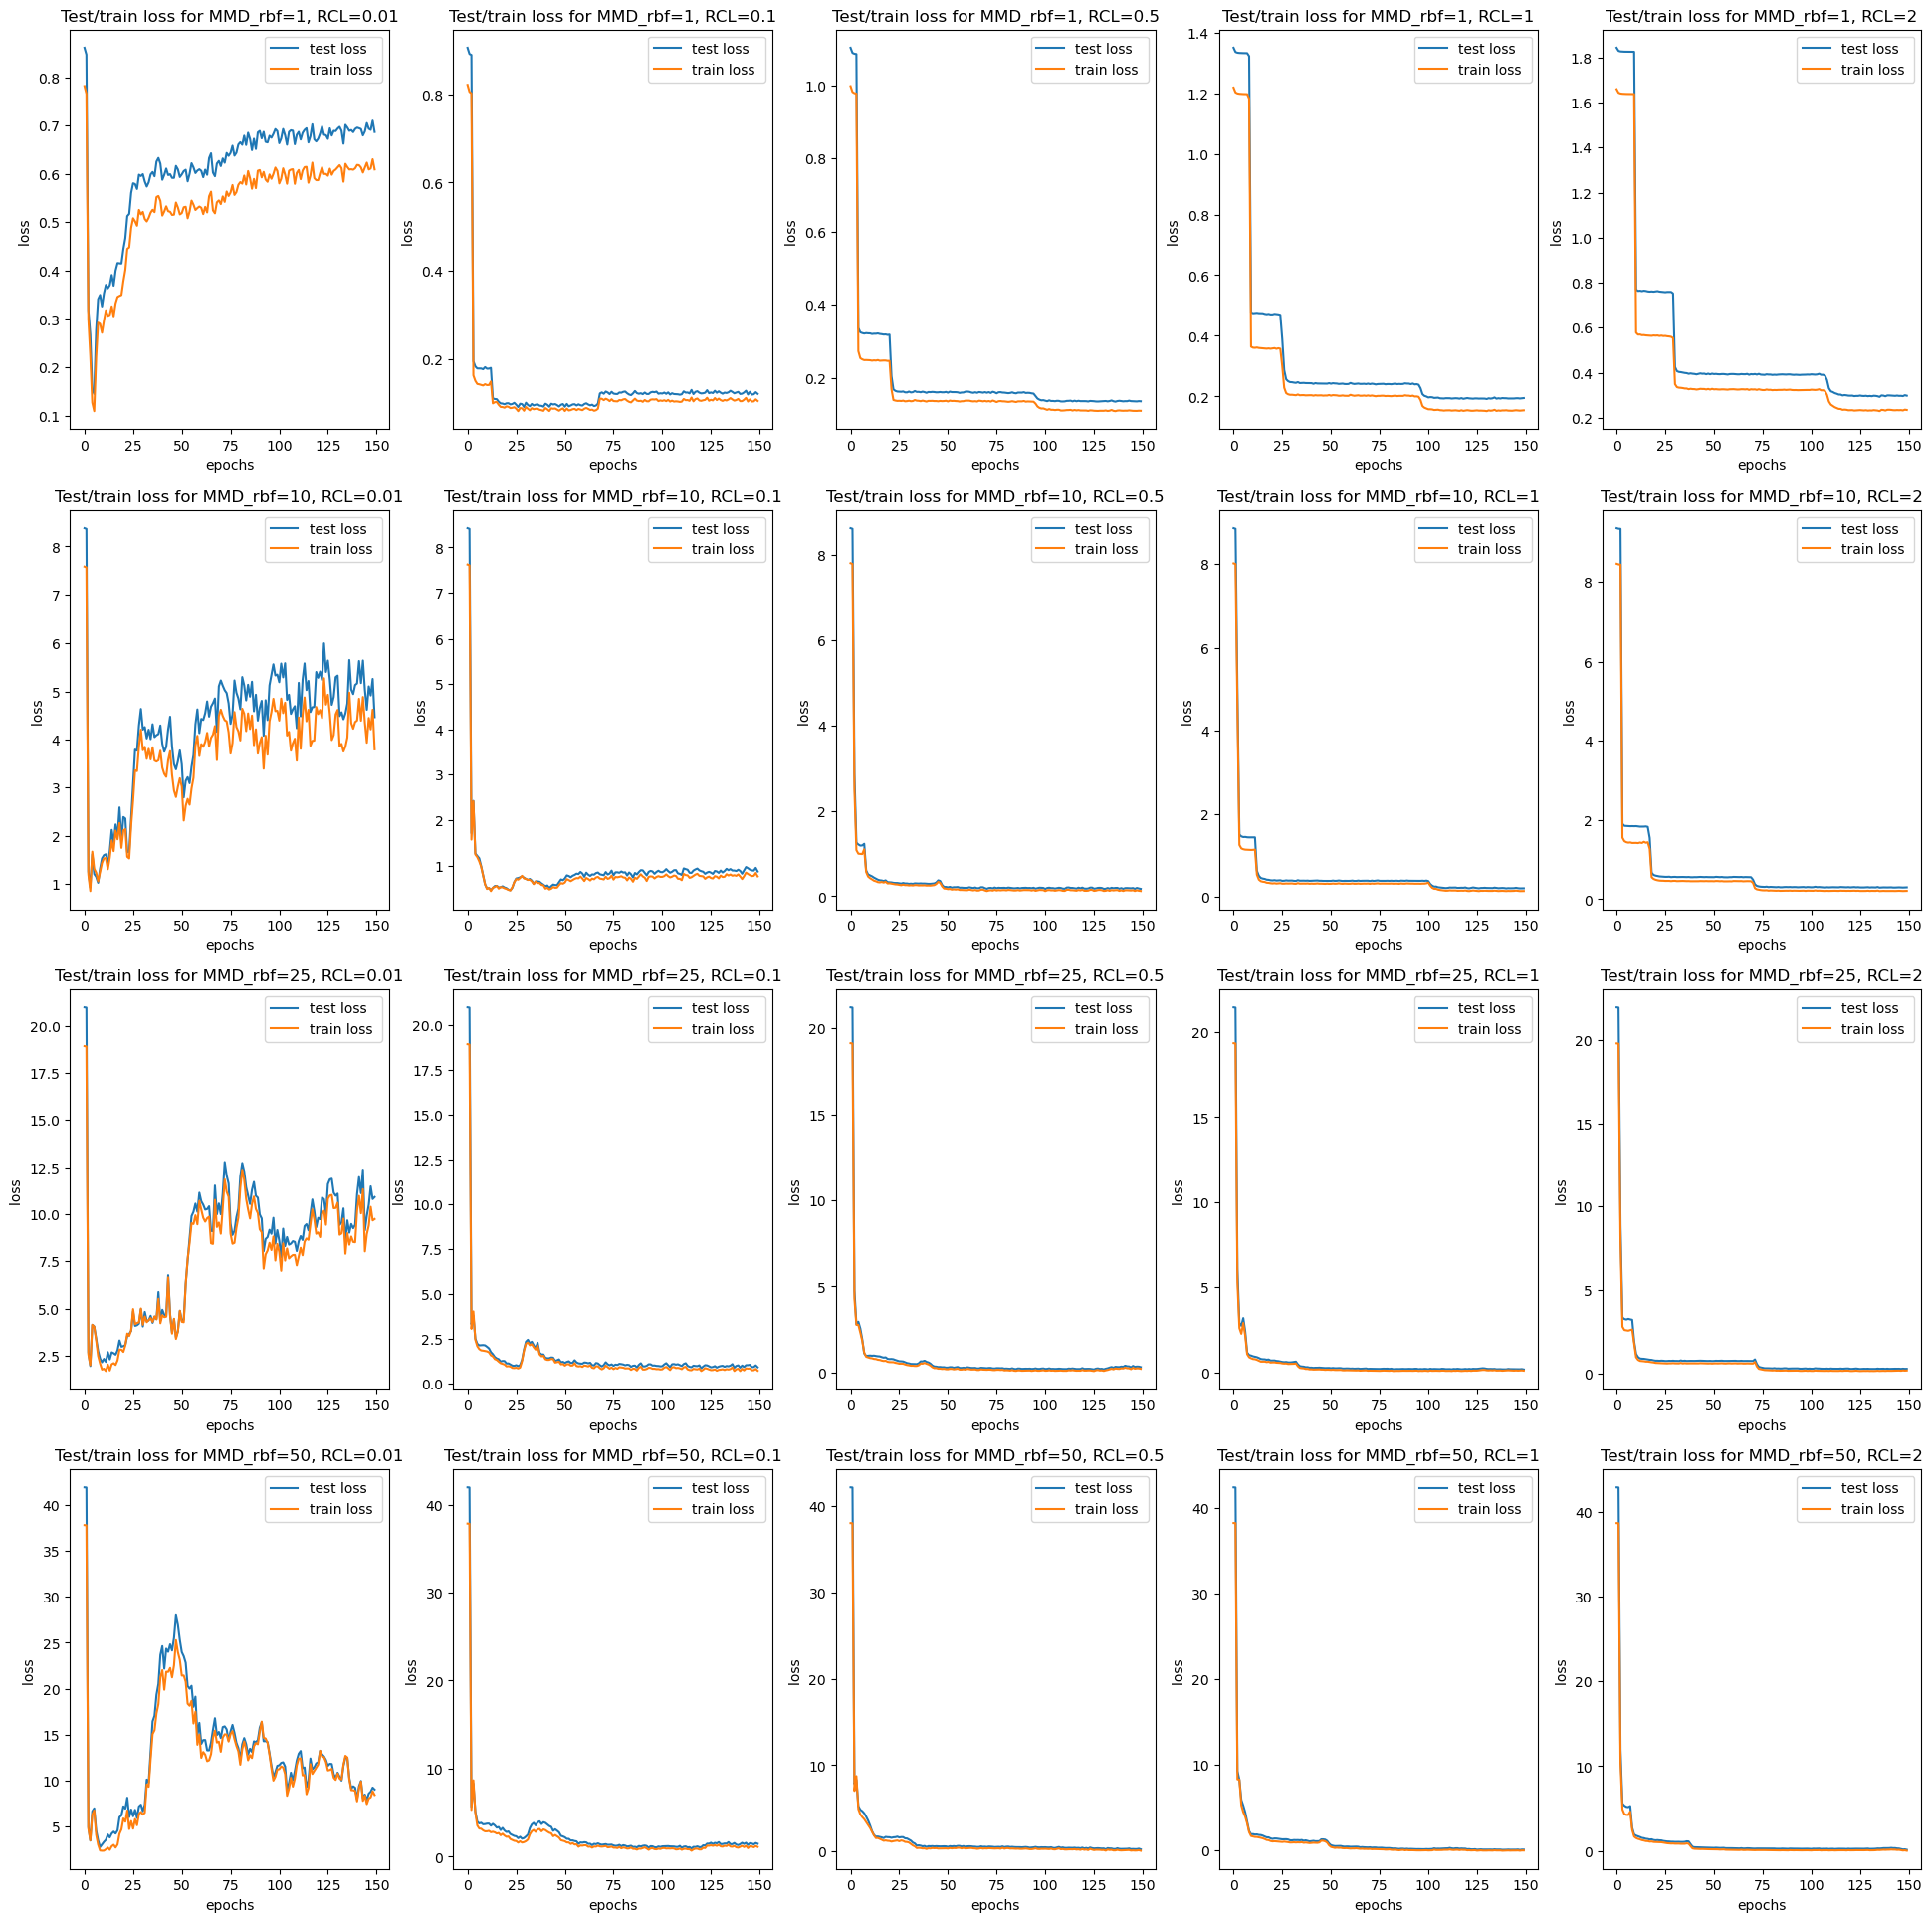

In [26]:
training_fig, training_axs = plt.subplots(nrows=len(args["s_range"]), ncols=len(args["t_range"]), figsize=(24, 24))

for i, s in enumerate(args["s_range"]):
    for j, t in enumerate(args["t_range"]):
        file_path = f'{get_savepath()}/{decoder_filename("06/06", args, suffix=name_fn(s,t)+"_metrics_hist")}'

        try: 
            with open(file_path, 'rb') as file:
                metrics_history = dill.load(file)


        
            plot_training(
                metrics_history["test_loss"], 
                metrics_history["train_loss"], 
                f"Test/train loss for {s_label}={s}, {t_label}={t}",
                "loss ",
                training_axs[i,j]
            )

        except FileNotFoundError:
            print(f"Failed to load s={s}, t={t}")

# Grid of comparison plots

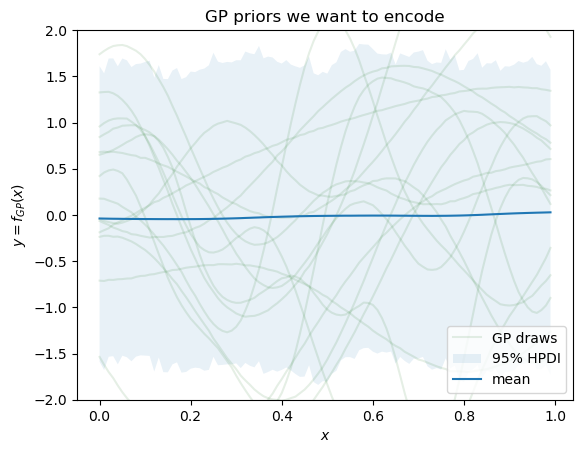

In [27]:
plot_draws_hpdi(gp_draws, args["x"], "GP priors we want to encode",  '$y=f_{GP}(x)$')


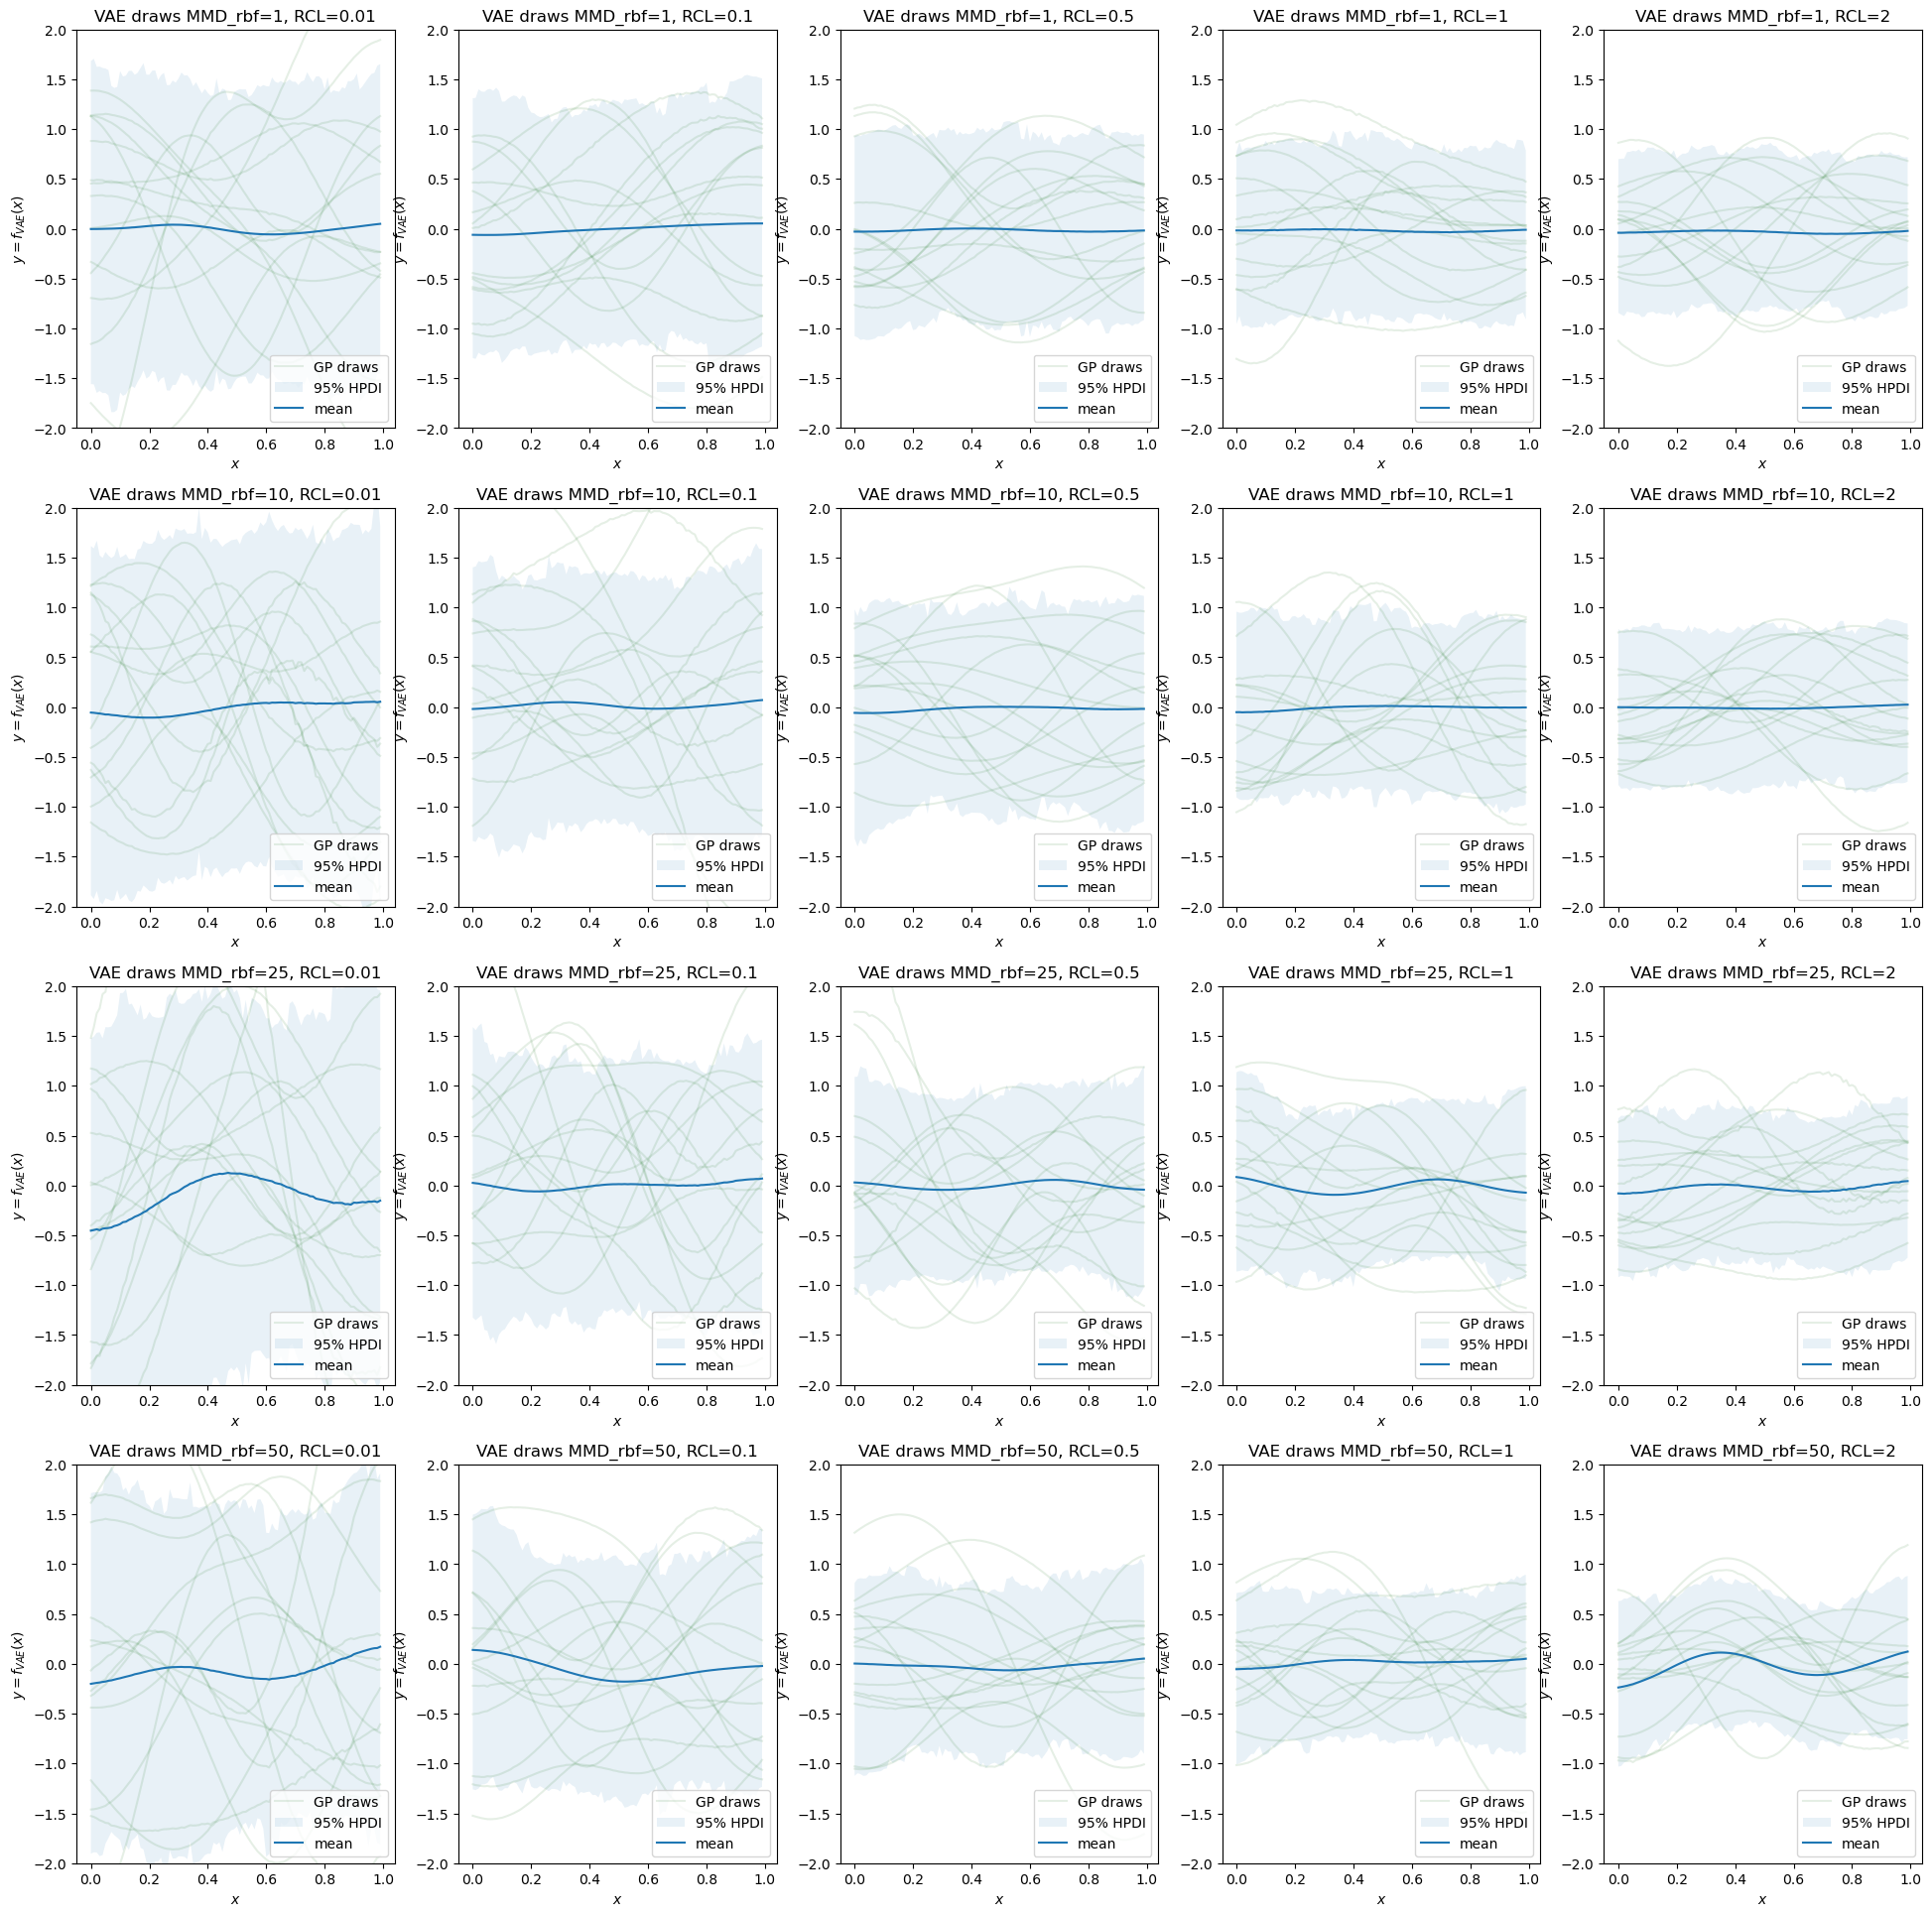

In [29]:
training_fig, training_axs = plt.subplots(nrows=len(args["s_range"]), ncols=len(args["t_range"]), figsize=(24, 24))

for i, s in enumerate(args["s_range"]):
    for j, t in enumerate(args["t_range"]):
        file_path = f'{get_savepath()}/{decoder_filename("06/06", args, suffix=name_fn(s,t))}'

        try:
            dummy_decoder = VAE_Decoder(
                hidden_dim1=args["hidden_dim1"], hidden_dim2=args["hidden_dim2"], out_dim=args["n"]
            )
            dummy_params = dummy_decoder.init(random.PRNGKey(0), jnp.ones((args["latent_dim"],)))
            file_path = f'{get_savepath()}/{decoder_filename("06/06", args, suffix=name_fn(s,t))}'

            with open(file_path, "rb") as file:
                bytes = file.read()

                args["decoder_params"] = serialization.from_bytes(dummy_params, bytes)

            plot_vae_predictive = Predictive(vae_sample, num_samples=1000)
            vae_draws = plot_vae_predictive(
                rng_key_predict,
                hidden_dim1=args["hidden_dim1"],
                hidden_dim2=args["hidden_dim2"],
                latent_dim=args["latent_dim"],
                out_dim=args["n"],
                decoder_params=args["decoder_params"],
            )["f"]

            plot_draws_hpdi(vae_draws, args["x"], f"VAE draws {s_label}={s}, {t_label}={t}", "$y=f_{VAE}(x)$", ax=training_axs[i, j])

        except FileNotFoundError:
            print(f"Failed to load s={s}, t={t}")

